In [4]:
from sklearn.datasets import fetch_openml
import numpy as np
from sklearn.model_selection import train_test_split
import time
import matplotlib.pyplot as plt
import pickle #optional

In [5]:
#Download do dataset e tratamento de dados:
xx , yy = fetch_openml('mnist_784', version=1, return_X_y=True)
X = xx
Y = yy
X = np.array(X.values/255) #Manter os valores de X entre 0 e 1
Y = np.array(Y.values)
m = X.shape[0]
n = X.shape[1] + 1
X = np.concatenate((np.ones([m,1]),X), axis=1) # Adicionando a coluna de 1's para suportar o bias
Y = Y.astype(np.int64)
cat = np.zeros([m,10])
for ind, num in enumerate(Y):
    cat[ind][num] = 1
Y = cat # Y agora é categórico-> ex: 3 = [0,0,0,1,0,0,0,0,0,0]
#Embaralhar e separar x e y em train e test:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.15, random_state=42) 

In [6]:
print('TAMANHOS:')
print(f'- X original: {X.shape[0]} x {X.shape[1]}')
print(f'- Y original: {Y.shape[0]} x {Y.shape[1]}')
print(f'- X Train: {x_train.shape[0]} x {x_train.shape[1]}')
print(f'- Y train: {y_train.shape[0]} x {y_train.shape[1]}')
print(f'- X Test: {x_test.shape[0]} x {x_test.shape[1]}')
print(f'- Y Test: {y_test.shape[0]} x {y_test.shape[1]}')

TAMANHOS:
- X original: 70000 x 785
- Y original: 70000 x 10
- X Train: 59500 x 785
- Y train: 59500 x 10
- X Test: 10500 x 785
- Y Test: 10500 x 10


2


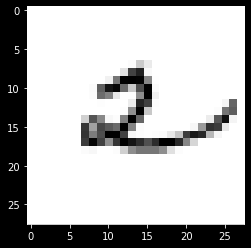

In [7]:
NumeroAleatorio = np.random.randint(0,59500)
plt.imshow(np.reshape(x_train[NumeroAleatorio][1:], [28,28]), cmap='Greys')
print(np.argmax(y_train[NumeroAleatorio]))

In [8]:
class MNISTalgorithm:
    def __init__(self, estrutura, epochs=10, alpha=0.1, batch_size=0, Regularizer=0.0):
        self.tamanhos = [x for x in estrutura if isinstance(x, int)]
        self.ativações = [x.lower() for x in estrutura if isinstance(x, str)]
        self.inputs = [epochs,alpha,batch_size,Regularizer]
        self.epochs = epochs
        self.alpha = alpha
        self.Reg = Regularizer
        self.batch_size = batch_size
        self.Thetas = self.Inicialização()
        self.CheckInputs()
    

    def CheckInputs(self): #Aviso de possiveis erros
        assert isinstance(self.epochs,int), 'ERRO: parametro "epochs" deve ser integer.'
        assert isinstance(self.alpha,float), 'ERRO: parametro "alpha" deve ser float.'
        assert isinstance(self.batch_size,int), 'ERRO: parametro "batch_size" deve ser integer.'
        assert isinstance(self.Reg,float), 'ERRO: parametro "Regularizer" deve ser float.'
        assert (self.tamanhos[0] == 784) and (self.tamanhos[-1] == 10),'ERRO: A primeira camada deve ter 784 neurônios e a ultima 10 neurônios.'
        assert len(self.ativações) == (len(self.tamanhos)-1), 'ERRO: Quantidade de camadas e ativações incompatível.'
        assert self.ativações[-1] == 'softmax', 'ERRO: A ultima ativação deve ser Softmax.'


    def Inicialização(self):# Inicializando Weights e Bias aleatoriamente
        Thetas = {}
        for layer in range(len(self.tamanhos)-1):
            Thetas[f'T{layer+1}'] = np.random.randn(self.tamanhos[layer]+1, self.tamanhos[layer+1])/10
        return Thetas


    def sigmoid(self, z):
        return 1/(1 + np.exp(-z))

    def dxsigmoid(self, z):
        return np.multiply(self.sigmoid(z),(1-self.sigmoid(z)))

    def softmax(self,x):
        x = np.array(x)
        e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return (e_x / e_x.sum(axis=1)[:,None])

    def Relu(self, x):
        return np.maximum(0,x)
    
    def dxRelu(self, x):
        return np.where(x >= 0, 1, 0)
    

    def Forward(self,X):
        '''Adicionando todo processo da Forward Propagation em um dicionario
        {"a1": [...], "z2": [...], "a2": [...], "z3": [...], ..... ,"h":[...]}'''
        X = np.matrix(X)
        m = X.shape[0]
        att = self.ativações
        Thetas = self.Thetas
        Forward_steps = {}
        Forward_steps['a1'] = X
        Ultimo_layer = int(len(self.tamanhos))
        for layer in range(1,Ultimo_layer):
            Forward_steps[f'z{layer+1}'] = np.dot(Forward_steps[f'a{layer}'], Thetas[f'T{layer}'])
            if att[layer-1] == 'sigmoid':
                Forward_steps[f'a{layer+1}'] = np.concatenate((np.ones([m,1]), self.sigmoid(Forward_steps[f'z{layer+1}'])), axis=1)
            elif att[layer-1] == 'softmax':
                Forward_steps[f'a{layer+1}'] = np.concatenate((np.ones([m,1]), self.softmax(Forward_steps[f'z{layer+1}'])), axis=1)
            elif att[layer-1] == 'relu':
                Forward_steps[f'a{layer+1}'] = np.concatenate((np.ones([m,1]), self.Relu(Forward_steps[f'z{layer+1}'])), axis=1)
            else:
                print('ERRO NAS ATIVAÇÕES')

        
        h = Forward_steps.pop(f'a{Ultimo_layer}')
        Forward_steps['h'] = h[:,1:]
        
        return Forward_steps
        

    def CostFunction(self):
        '''É calculado a logistic Cost Function para todas as classes(10) e todas as rows(59500)'''
        Y = self.Y
        X = self.X
        Thetas = self.Thetas
        m = self.m
        Reg = self.Reg
        soma_weights = 0
        for i in range(len(Thetas)):
            weights = Thetas[f'T{i+1}']
            weights[0] = 0
            soma_weights += np.sum(weights**2)
        Forward_dict = self.Forward(X)
        h = Forward_dict['h']
        soma = np.sum((np.multiply(-Y , np.log(h)) - np.multiply((1-Y),(np.log(1-h)))))
        J = soma/m + (Reg/(2*m)) * soma_weights
        return J


    def Gradients(self,X,Y):
        '''Calcular a derivada de todos Thetas w.r.t Cost function, 
        é organizado utilizando um dicionario contendo os deltas.
        {...., "delta2": [...], "delta1": [...]}'''
        X = np.matrix(X)
        Y = np.matrix(Y)
        m = X.shape[0]
        Thetas = self.Thetas
        n_layers = len(self.tamanhos)
        att = self.ativações
        Thetas_grad = []

        Forward_list = self.Forward(X)
        deltas = {}
        deltas[f'delta{n_layers}'] = Forward_list['h'] - Y # delta4
        for i in range(n_layers-1,1,-1):# 3 ... 2
            if att[i-2] == 'sigmoid':
                deltas[f'delta{i}'] = np.multiply((np.dot(deltas[f'delta{i+1}'],Thetas[f'T{i}'][1:].T)) , self.dxsigmoid(Forward_list[f'z{i}']))
            elif att[i-2] == 'relu':
                deltas[f'delta{i}'] = np.multiply((np.dot(deltas[f'delta{i+1}'],Thetas[f'T{i}'][1:].T)) , self.dxRelu(Forward_list[f'z{i}']))
        
        for c in range(len(deltas)):#0 ... 1 ... 2
            BigDelta = np.array(np.dot(deltas[f'delta{c+2}'].T, Forward_list[f'a{c+1}']))
            weights = Thetas[f'T{c+1}']
            weights[0] = 0 #Coluna dos bias vira 0's
            grad = np.array(BigDelta + (self.Reg * weights.T))/m
            Thetas_grad.append(grad)
        return Thetas_grad #[T1_grad, T2_grad, T3_grad]


    def Precisao(self, X,Y):
        '''É calculado a porcentagem em que o algoritmo classificou corretamente a imagem.'''
        Forward_list = self.Forward(X)
        h = Forward_list['h']
        y_hat = np.argmax(h, axis=1)[:,None]
        y = np.argmax(Y, axis=1)[:,None]
        return np.mean(y_hat == y)


    def train(self, X, Y,x_test,y_test):
        '''Função que organiza os precessos para o aprendizado adequedo, utilizando os parametros inseridos.
        Após <num> epochs, é feito o calculo do Cost, calculo da precisão em relação ao Treinamento e ao 
        Teste(provando sua capacidade de generalizar).'''
        Thetas = self.Thetas
        self.X = X
        self.Y = Y
        self.m = X.shape[0]
        j_history = []
        sec1 = time.time()
        if self.batch_size <= 0:
            b_size = self.m
            print(f'Usando batch de tamanho {b_size}..')
        elif isinstance(self.batch_size, int) and (1<= self.batch_size <= self.m):
            b_size = self.batch_size
        else:
            return 'ERRO EM BATCH_SIZE'
        for ep in range(self.epochs):
            m = self.m
            a = np.array([0,b_size])
            num = 1 #Coloque um numero maior se utilizar muitas epochs
            
            for i in range(m // b_size):
                inx = a + b_size*i
                grad_list = self.Gradients(X[inx[0]:inx[1]], Y[inx[0]:inx[1]])
                for g in range(len(grad_list)):
                    self.Thetas[f'T{g+1}'] = self.Thetas[f'T{g+1}'] - self.alpha*np.array(grad_list[g]).T
            
            if (ep+1) % num == 0: #
                J = self.CostFunction()
                j_history.append(J)
                accu_train = self.Precisao(X,Y)
                accu_test = self.Precisao(x_test,y_test)
                sec2 = time.time()
                tempo_gasto = sec2 - sec1
                print(f'Epoch: {ep+1}; Cost: {J:.5f}: Accuracy Train: {accu_train:.5%}; Accuracy Test: {accu_test:.5%}; Tempo Gasto: {tempo_gasto:.2f} s')
        return j_history, self.Thetas


In [9]:
model = MNISTalgorithm([784, 'relu', 200,'sigmoid',80, 'softmax', 10], epochs=10, alpha=0.1, batch_size=100)

In [10]:
j_history, trained_thetas = model.train(x_train,y_train,x_test,y_test)

Epoch: 1; Cost: 0.62191: Accuracy Train: 90.09244%; Accuracy Test: 89.96190%; Tempo Gasto: 9.17 s
Epoch: 2; Cost: 0.45427: Accuracy Train: 92.42353%; Accuracy Test: 92.28571%; Tempo Gasto: 17.42 s
Epoch: 3; Cost: 0.37289: Accuracy Train: 93.71765%; Accuracy Test: 93.42857%; Tempo Gasto: 25.19 s
Epoch: 4; Cost: 0.31886: Accuracy Train: 94.64874%; Accuracy Test: 94.26667%; Tempo Gasto: 36.19 s
Epoch: 5; Cost: 0.27948: Accuracy Train: 95.35462%; Accuracy Test: 94.88571%; Tempo Gasto: 45.94 s
Epoch: 6; Cost: 0.24890: Accuracy Train: 95.88739%; Accuracy Test: 95.31429%; Tempo Gasto: 56.25 s
Epoch: 7; Cost: 0.22424: Accuracy Train: 96.34790%; Accuracy Test: 95.55238%; Tempo Gasto: 66.99 s
Epoch: 8; Cost: 0.20376: Accuracy Train: 96.66218%; Accuracy Test: 95.84762%; Tempo Gasto: 77.46 s
Epoch: 9; Cost: 0.18653: Accuracy Train: 96.99160%; Accuracy Test: 96.02857%; Tempo Gasto: 88.28 s
Epoch: 10; Cost: 0.17176: Accuracy Train: 97.24706%; Accuracy Test: 96.26667%; Tempo Gasto: 98.93 s


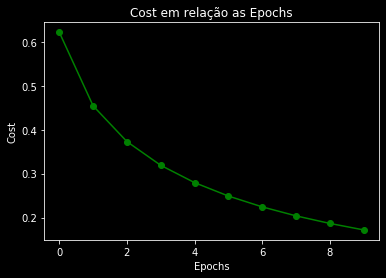

In [13]:
plt.plot(j_history, 'go-',label='Cost')
plt.title('Cost em relação as Epochs')
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.show()

In [49]:
#SALVAR O MODELO APÓS O TREINO
a_file = open('MNIST_trained.pkl', 'wb')
pickle.dump(trained_thetas, a_file)
a_file.close()